<a href="https://colab.research.google.com/github/gwangjinjeong/Study_DeepLearning/blob/main/Time_series/1_Statistical_Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Trend and Seasonality

In [ ]:
def trend(time, slope=0):
    return slope * time

상승 추세인 시계열을 만들어 봅시다.

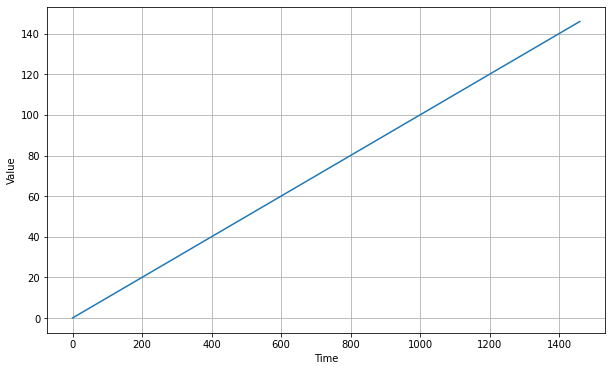

In [ ]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

이제 계절 패턴을 사용하여 시계열을 생성해 보겠습니다.

In [ ]:
def seasonal_pattern(season_time):
    # 임의의 패턴일 뿐, 원한다면 변경할 수 있습니다
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    # 각 시기에 같은 패턴을 반복한다
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
    

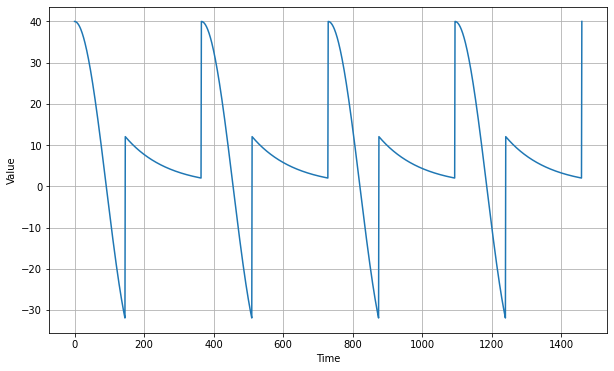

In [ ]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

이제 트렌드와 계절성을 모두 갖춘 시계열을 생성해 보겠습니다.

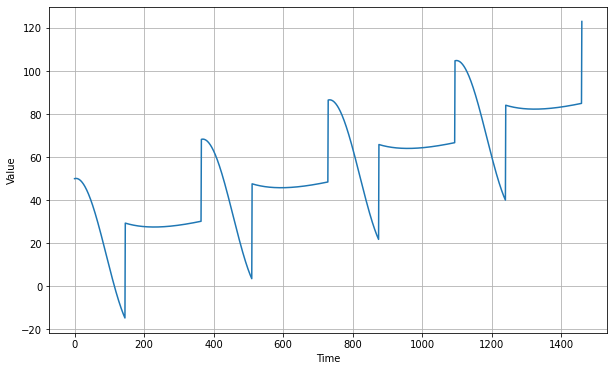

In [ ]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# 노이즈(Noise)

실제로 위처럼 이상적인 Signal를 가진 시계열은 거의 없다. 일반적으론 약간의 노이즈(Noise)을 가지고 있고, 신호 대 잡음 비율은 때때로 매우 낮을 수 있다. 노이즈를 추가시켜 보자.

In [ ]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

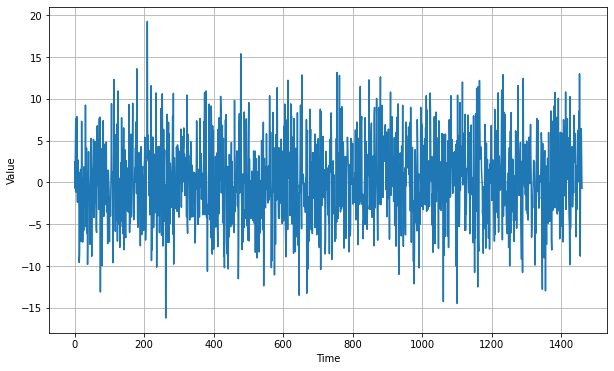

In [ ]:
noise_level = 5
white_noise = noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, white_noise)
plt.show()


이제 이 백색 노이즈를 시계열에 추가해 보겠습니다.

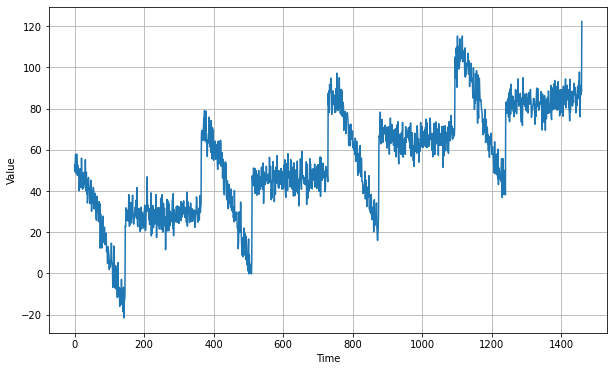

In [ ]:
series += white_noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


충분히 현실적인 데이터가 나왔으니, 예측해 보자.<br>우선 training period과 validation period 두 가지 기간으로 나눌 것이며, 분할은 Time=1000인곳에서 이루어진다.

# Auto Correlation
척도가 달라도 예측 가능한 형태를 따르는 데이터

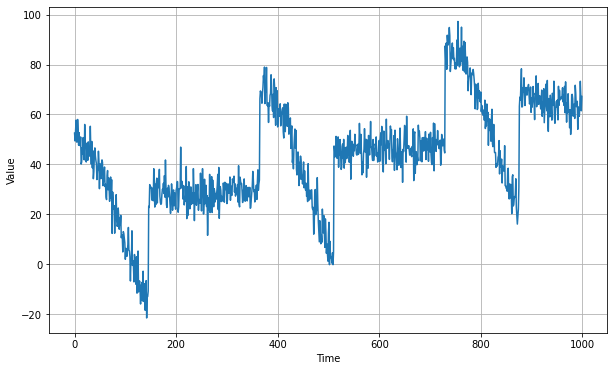

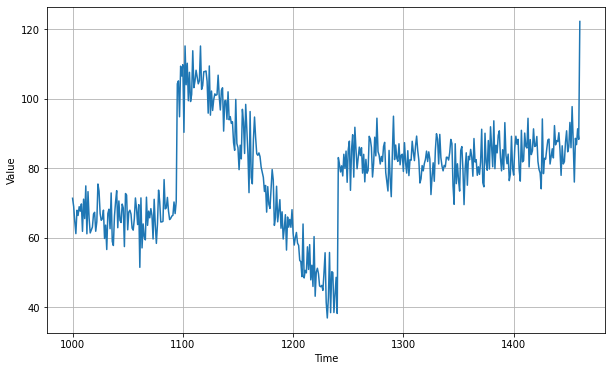

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [ ]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [ ]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

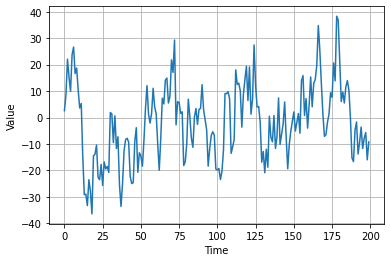

In [ ]:
series_autocorr = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series_autocorr[:200])
plt.show()

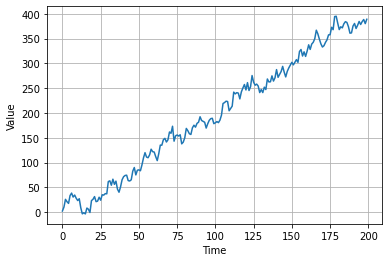

In [ ]:
series_autocorr = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series_autocorr[:200])
plt.show()

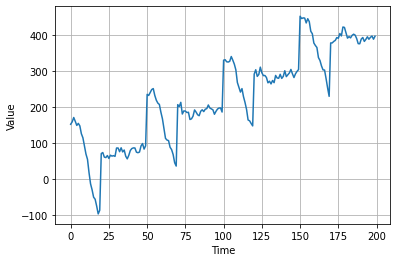

In [ ]:
series_autocorr = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series_autocorr[:200])
plt.show()

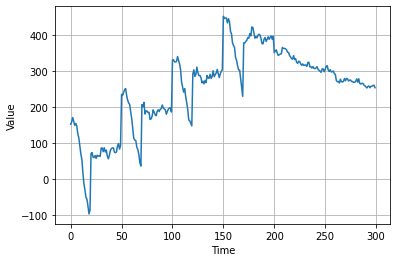

In [ ]:
series_autocorr1 = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series_autocorr2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series_autocorr1[200:] = series_autocorr2[200:]
plot_series(time[:300], series_autocorr1[:300])
plt.show()

In [ ]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

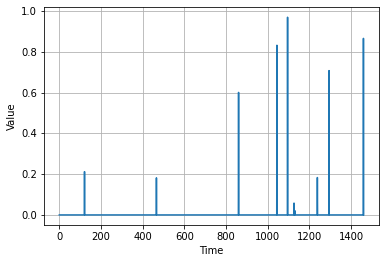

In [ ]:
series_impulse = impulses(time, 10, seed=42)
plot_series(time, series_impulse)
plt.show()

In [ ]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

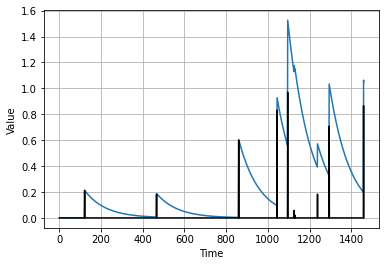

In [ ]:
signal = impulses(time, 10, seed=42)
series_autocorr = autocorrelation(signal, {1: 0.99})
plot_series(time, series_autocorr)
plt.plot(time, signal, "k-")
plt.show()

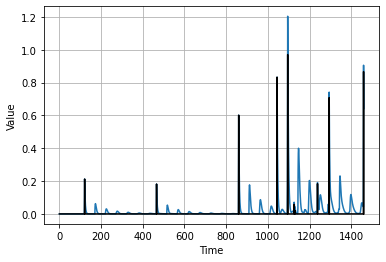

In [ ]:
signal = impulses(time, 10, seed=42)
series_autocorr = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series_autocorr)
plt.plot(time, signal, "k-")
plt.show()

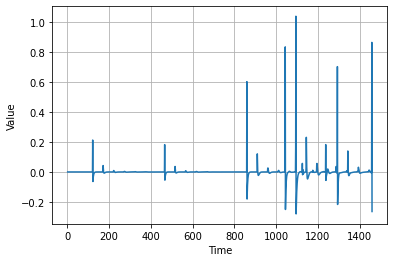

In [ ]:
series_diff1 = series_autocorr[1:] - series_autocorr[:-1]
plot_series(time[1:], series_diff1)

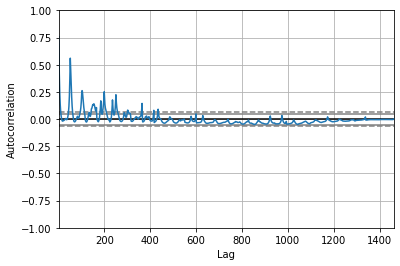

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series_autocorr)

다음 코드 블록은 계절성, 추세 및 약간의 노이즈가 있는 시계열을 설정합니다.

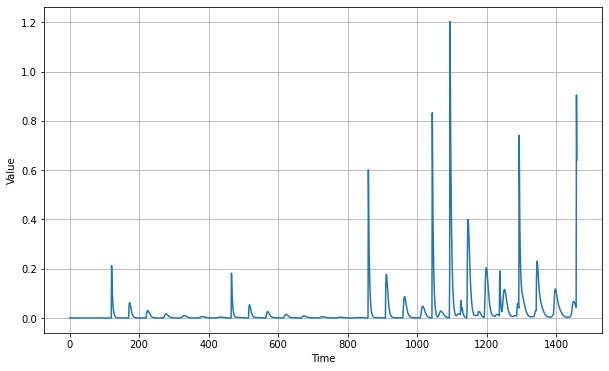

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series_autocorr)
plt.show()

#  Statistical Time-Series forecasting

# Naive Forecast

In [ ]:
naive_forecast = series[split_time - 1:-1]

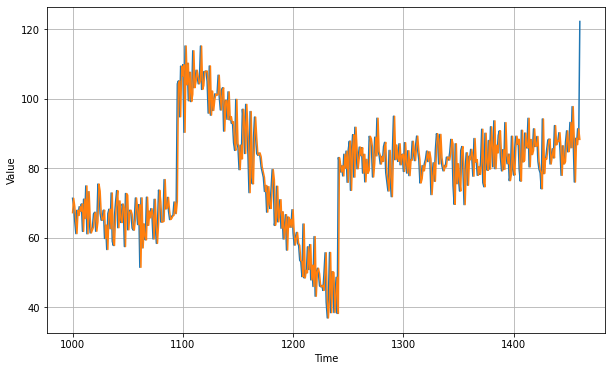

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

검증 기간을 확대해보겠습니다.

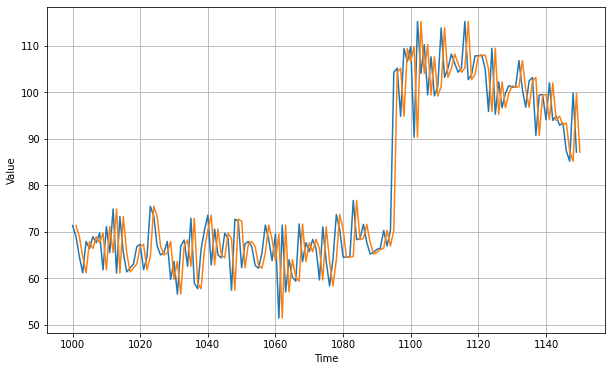

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

Naive Forecast가 시계열보다 한 step씩 늦어지는 것을 볼 수 있습니다.

이제 validation 기간의 예측과 MSE(평균 제곱 오차), MAE(평균 절대 오차)를 계산해 보자.

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.82753366856369
5.9379085153216735


# Moving Average

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

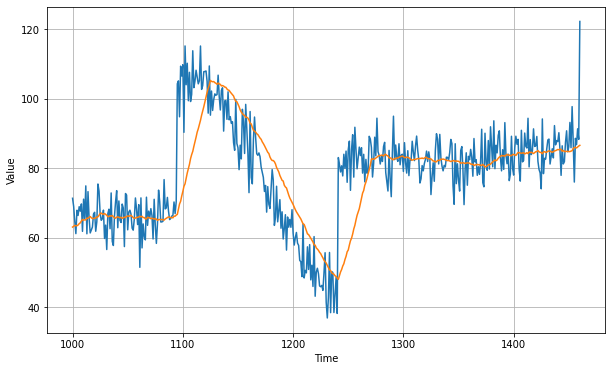

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.6745665143116
7.142418570620878


이건 Navie Forecast 보다 더 안좋은 성능이 나온다. 이동 평균(Moving Average)은 추세나 계절성을 예측하지 못하는걸 확인했다.

# Differencing
차분(differencing)을 사용하여 제거해 보겠습니다. 계절성 기간은 365일이므로 시간 *t* – 365 값을 시간 *t* 값에서 뺍니다.

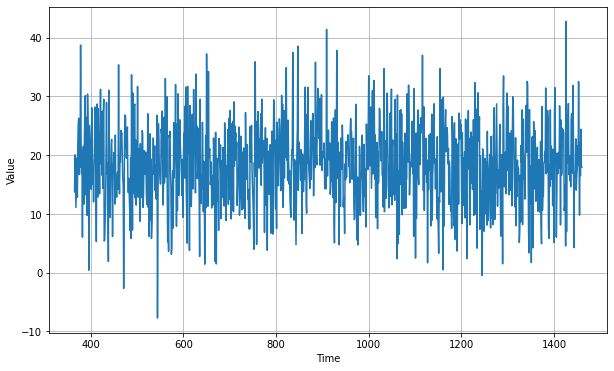

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

이제 추세와 계절성이 사라졌으니 이동 평균을 사용할 수 있다.

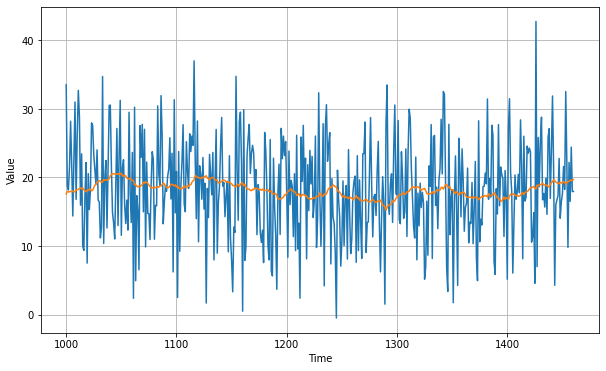

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

이제 t – 365의 과거 값을 추가하여 트렌드와 계절성을 되살려 보자.

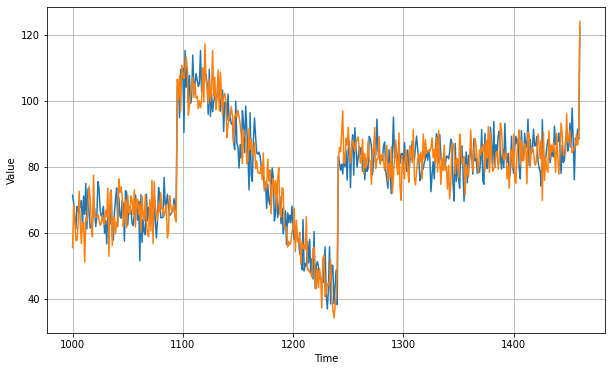

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.973659999691854
5.839310562995894


Navie forecast 보다 성능이 좋은 것을 볼 수 있다.

그러나, 예측에 노이즈가 많이 껴보인다. 왜냐하면 Noise가 많았던 과거 값을 추가했기 때문입니다.

#  Moving averaging on past values
노이즈 좀 제거해 보자.

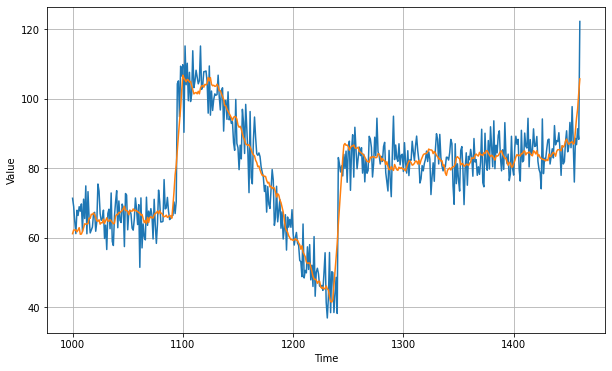

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226092870011
4.569441847863209


# Result

In [ ]:
print('# Naive_forecast')
print('MSE : ',keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print('MAE : ',keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
print('# Moving Average')
print('MSE : ',keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print('MAE : ',keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
print('# Differencing')
print('MSE : ',keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print('MAE : ',keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())
print('# Differencing + Moving Average')
print('MSE : ',keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print('MAE : ',keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

# Naive_forecast
MSE :  61.82753366856369
MAE :  5.9379085153216735
# Moving Average
MSE :  106.6745665143116
MAE :  7.142418570620878
# Differencing
MSE :  52.973659999691854
MAE :  5.839310562995894
# Differencing + Moving Average
MSE :  33.45226092870011
MAE :  4.569441847863209
